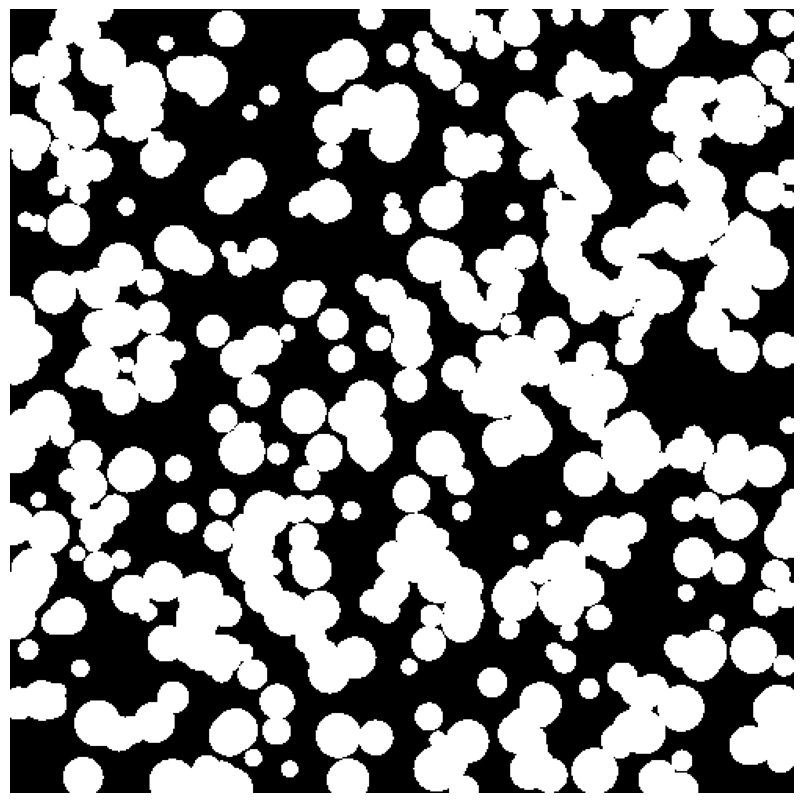

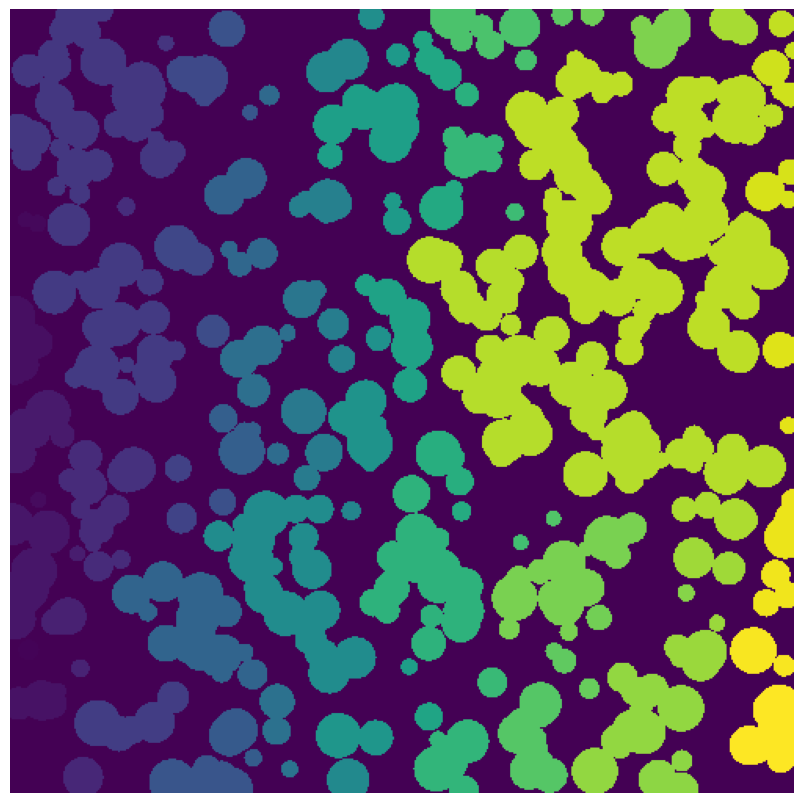

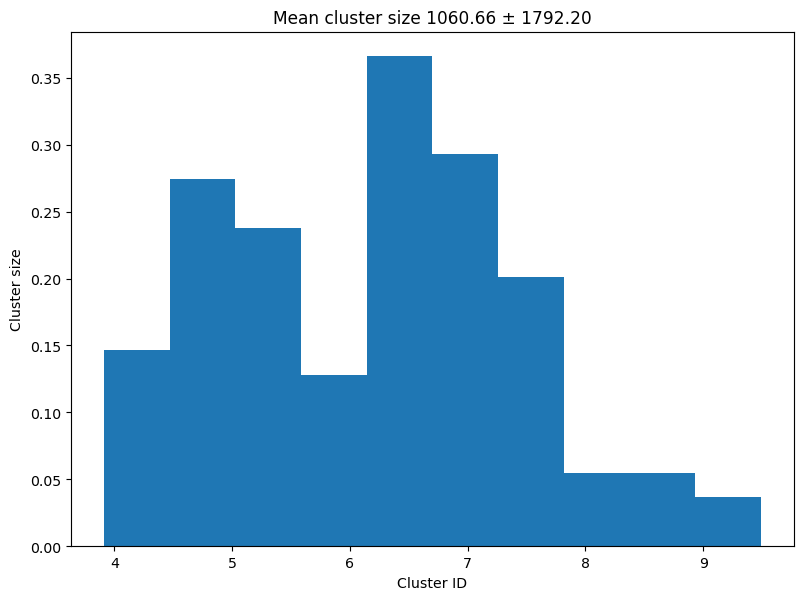

In [1]:
import tkinter as tk
from tkinter import ttk
import torch
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from common import find_clusters_bounded, find_clusters_circular


def sample_circles_percolation(positions_dist, circle_size_dist, N_circles, N_grid, device='cpu'):
    XY = positions_dist.sample((N_circles, 2)).to(device)
    size_sq = circle_size_dist.sample((N_circles,)).to(device)
    size_sq=(size_sq).pow(2)

    grid = torch.zeros((N_grid, N_grid), device=device)
    grid_XY = torch.meshgrid(
        torch.linspace(0,1,N_grid, device=device),
        torch.linspace(0,1,N_grid, device=device),
        indexing="ij"
    )
    
    GX,GY = grid_XY
    for ind, r2 in zip(XY[:, :, None, None], size_sq[:, None, None]):
        mask = (GX - ind[0]).pow(2) + (GY - ind[1]).pow(2) <= r2
        grid += mask
    grid[grid > 0] = 1
    return grid

def sample_non_intersection_circles(N_circles,N_grid,radius,device='cpu'):
    grid = torch.zeros((N_grid, N_grid), device=device)
    r2=float(radius**2)
    
    grid_XY = torch.meshgrid(
        torch.linspace(0,1,N_grid, device=device),
        torch.linspace(0,1,N_grid, device=device),
        indexing="ij"
    )
    
    GX,GY = grid_XY
    occupied = grid*1.0
    for c in range(N_circles):
        free_pos_x,free_pos_y = torch.where(occupied==0)
        if len(free_pos_x)==0 or len(free_pos_y)==0:
            print("Not enough space to fit circles")
            break
        point = torch.randint(0,len(free_pos_x),(1,),device=device)
        x = free_pos_x[point].to(device)/N_grid
        y = free_pos_y[point].to(device)/N_grid
        mask = (GX - x[:,None,None]).pow(2) + (GY - y[:,None,None]).pow(2)
        
        
        occupied += mask[0] <= r2*3.6 # left small intersection region
        grid += mask[0] <= r2
    
    grid[grid > 0] = 1
    return grid

class CirclesApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Circle Percolation Generator")
        self.geometry("500x300")

        # Parameters
        tk.Label(self, text="Number of circles:").grid(row=0, column=0, sticky='w')
        self.N_circles_var = tk.IntVar(value=500)
        tk.Entry(self, textvariable=self.N_circles_var).grid(row=0, column=1)

        tk.Label(self, text="Grid size (N_grid):").grid(row=1, column=0, sticky='w')
        self.N_grid_var = tk.IntVar(value=500)
        tk.Entry(self, textvariable=self.N_grid_var).grid(row=1, column=1)

        tk.Label(self, text="Circle size low:").grid(row=2, column=0, sticky='w')
        self.low_var = tk.DoubleVar(value=0.01)
        tk.Entry(self, textvariable=self.low_var).grid(row=2, column=1)

        tk.Label(self, text="Circle size high:").grid(row=3, column=0, sticky='w')
        self.high_var = tk.DoubleVar(value=0.03)
        tk.Entry(self, textvariable=self.high_var).grid(row=3, column=1)

        tk.Label(self, text="Clustering algorithm:").grid(row=4, column=0, sticky='w')
        self.algorithm_var = tk.StringVar(value="find_clusters_bounded")
        algo_combo = ttk.Combobox(self, textvariable=self.algorithm_var, values=[
            "find_clusters_bounded", "find_clusters_circular"], state='readonly')
        algo_combo.grid(row=4, column=1)
        
        tk.Label(self, text="Percolation system:").grid(row=5, column=0, sticky='w')
        self.percolation_var = tk.StringVar(value="intersections")
        percolation_combo = ttk.Combobox(self, textvariable=self.percolation_var, values=[
            "intersections", "non-intersections"], state='readonly')
        percolation_combo.grid(row=5, column=1)

        # Generate button
        tk.Button(self, text="Generate", command=self.generate).grid(row=6, column=0, columnspan=2, pady=10)

        # Hold references to figures and canvases
        self.fig_A = self.canvas_A = self.win_A = None
        self.fig_C = self.canvas_C = self.win_clusters = None
        self.fig_H = self.canvas_H = self.win_hist = None

    def generate(self):
        N_circles = self.N_circles_var.get()
        N_grid = self.N_grid_var.get()
        low = self.low_var.get()
        high = self.high_var.get()
        algo_name = self.algorithm_var.get()
        percolation_name = self.percolation_var.get()

        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        positions_dist = torch.distributions.Uniform(0, 1)
        circle_size_dist = torch.distributions.Uniform(low, high)

        # Generate binary grid
        if percolation_name=='intersections':
            grid = sample_circles_percolation(
                positions_dist, circle_size_dist, N_circles, N_grid, device
            )
        else:
            grid = sample_non_intersection_circles(
                N_circles,N_grid,circle_size_dist.sample((1,)),device
            )

        # Compute clusters
        if algo_name == "find_clusters_bounded":
            clusters = find_clusters_bounded(grid, device)
        else:
            clusters = find_clusters_circular(grid, device)
        clusters = clusters.cpu()

        # Prepare cluster colors
        mask = clusters > 0
        clusters_slice = clusters[mask]
        n_clusters = clusters_slice.max() if mask.any() else 1
        colors = torch.linspace(0, 1, n_clusters + 1)[clusters]
        colors[clusters == -1] = 0

        # Compute log-histogram of cluster sizes
        cluster_distribution = [(clusters == c).sum() for c in clusters.unique()]
        cluster_distribution = torch.tensor(cluster_distribution)
        cluster_distribution = cluster_distribution[cluster_distribution.argsort()]
        dist = cluster_distribution[:-2]  # skip background and largest cluster
        if len(dist) > 0:
            log_dist = torch.log(dist.float())
        else:
            log_dist = torch.tensor([])

        # --- Update or create plots ---

        # Binary matrix window
        if self.win_A is None or not tk.Toplevel.winfo_exists(self.win_A):
            self.win_A = tk.Toplevel(self)
            self.win_A.title("Binary grid (circles)")
            self.fig_A, ax_A = plt.subplots(figsize=(8, 8))
            self.canvas_A = FigureCanvasTkAgg(self.fig_A, master=self.win_A)
            self.canvas_A.get_tk_widget().pack()
        else:
            ax_A = self.fig_A.axes[0]
            ax_A.clear()
        ax_A.imshow(grid.T.cpu(), cmap='gray')
        ax_A.axis('off')
        self.fig_A.tight_layout()
        self.canvas_A.draw()

        # Cluster colors window
        if self.win_clusters is None or not tk.Toplevel.winfo_exists(self.win_clusters):
            self.win_clusters = tk.Toplevel(self)
            self.win_clusters.title("Clusters")
            self.fig_C, ax_C = plt.subplots(figsize=(8, 8))
            self.canvas_C = FigureCanvasTkAgg(self.fig_C, master=self.win_clusters)
            self.canvas_C.get_tk_widget().pack()
        else:
            ax_C = self.fig_C.axes[0]
            ax_C.clear()
        ax_C.imshow(colors.T.cpu())
        ax_C.axis('off')
        self.fig_C.tight_layout()
        self.canvas_C.draw()

        # Log-histogram window
        if self.win_hist is None or not tk.Toplevel.winfo_exists(self.win_hist):
            self.win_hist = tk.Toplevel(self)
            self.win_hist.title("Log-histogram of cluster sizes")
            self.fig_H, ax_H = plt.subplots(figsize=(8, 6))
            self.canvas_H = FigureCanvasTkAgg(self.fig_H, master=self.win_hist)
            self.canvas_H.get_tk_widget().pack()
        else:
            ax_H = self.fig_H.axes[0]
            ax_H.clear()
        if len(log_dist) > 0:
            ax_H.hist(log_dist.cpu(), density=True)
            ax_H.set_title(f"Mean cluster size {dist.float().mean():0.2f} ± {dist.float().std():0.2f}")
        else:
            ax_H.text(0.5, 0.5, "No clusters", ha='center')
        ax_H.set_xlabel("Cluster ID")
        ax_H.set_ylabel("Cluster size")
        self.fig_H.tight_layout()
        self.canvas_H.draw()


if __name__ == "__main__":
    app = CirclesApp()
    app.mainloop()
